# Построение оптимальной модели для обнаружения мин

**Повысьте точность модели по обнаружению мин до 90 % на тестовой выборке.**

Можно использовать различные варианты слоев Dropout и BatchNormalization. Можно менять количество примеров в обучающей и проверочной выборках, но нельзя менять количество примеров в тестовой.

In [1]:
from pathlib import Path
import sys
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

Задать количество эпох для обучения.

In [3]:
EPOCHS = 100

## Подготовка данных

Определить путь для загрузки датасета.

In [4]:
path = Path.cwd().parent.parent / 'data' / 'datasets' / '02-sonar' / 'sonar.csv'

Выполнить загрузку датасета.

In [5]:
df = pd.read_csv(path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Выделить атрибуты и целевую переменную.

In [6]:
x = df.values[:, 0:60].astype(np.float)
y = np.where(
    df.values[:, 60] == 'M',
    1,
    0
)

print(f"{x.shape}, {y.shape}")

(208, 60), (208,)


Разделить датасет на обучающую и тестовую выборки.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    shuffle=True
)

print(f"{x_train.shape}, {y_train.shape}")
print(f"{x_test.shape}, {y_test.shape}")

(166, 60), (166,)
(42, 60), (42,)


### Создание нейронной сети

Вспомогательный класс для создания нейронной сети.

In [8]:
class NetBuilder:

    @staticmethod
    def build(
        layers: Tuple[int, ...],
        dropout_rate=0.5
    ) -> Sequential:

        if not layers or not isinstance(layers, Iterable) or not layers:
            raise RuntimeError(f"Illegal layers collection {layers}")

        model = Sequential()
        for idx, n in enumerate(layers):
            if n <= 0:
                raise RuntimeError(f"Illegal number of the neurons {n}")
                
            if idx == 0:
                model.add(Dense(n, input_dim=60))
            else:
                model.add(Dense(n))

            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss='binary_crossentropy', 
            optimizer=Adam(lr=0.001), 
            metrics=['accuracy']
        )
        return model

In [9]:
net = NetBuilder.build(layers=(128, 32))

net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0

## Обучение нейронной сети

In [10]:
history = net.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 0.8748 - accuracy: 0.4819
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.8616 - accuracy: 0.5241
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6764 - accuracy: 0.6566
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.6145
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6026 - accuracy: 0.6386
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.6446
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.6566
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6008 - accuracy: 0.6566
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5363 - accuracy: 0.7048
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4982 - accuracy: 0.7892
Epoch 11/

Отобразить процесс изменения loss и accuracy в процессе обучения.

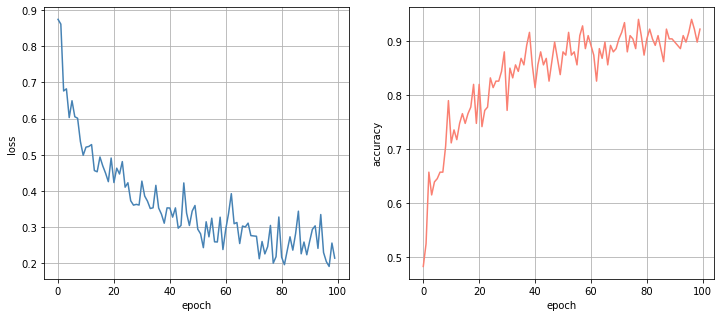

In [11]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

axes = axes.flatten()

axes[0].plot(
    history.epoch,
    history.history['loss'],
    color='steelblue'
)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].grid(True)

axes[1].plot(
    history.epoch,
    history.history['accuracy'],
    color='salmon'
)
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].grid(True)

plt.show();

Сохранить веса обученных нейронных сетей.

In [12]:
path = Path.home() / 'aiu-02-sonar-pro-model.h5'

net.save_weights(path)
net.load_weights(path)

## Выполнить тестирование нейронной сети

In [13]:
score = net.evaluate(x_test, y_test, verbose=1)

print(f"\nTest loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

2/2 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.9286

Test loss: 0.19628307223320007
Test accuracy: 0.9285714030265808


Таким образом полученная точность составляет 92.8%, что больше требуемой точности 90%.